# Module

In [1]:
import torch
import torch.nn as nn
import numpy as np
from numpy import dot
from numpy.linalg import norm
import torch.nn.functional as F
import seaborn as sns
import pandas as pd
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt

# Cosine Similarity

In [2]:
def cos_sim(A, B):
       return dot(A, B)/(norm(A)*norm(B))

# Model

In [3]:
class Autorec(nn.Module):
    def __init__(self, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, dropout, input_size):
        super(Autorec, self).__init__()
        self.input_size = input_size
        self.hidden_size_1 = hidden_size_1
        self.hidden_size_2 = hidden_size_2
        self.hidden_size_3 = hidden_size_3
        self.hidden_size_4 = hidden_size_4

        self.encoder_l1 = nn.Linear(self.input_size, self.hidden_size_1)
        self.encoder_l2 = nn.Linear(self.hidden_size_1, self.hidden_size_2)
        self.encoder_l3 = nn.Linear(self.hidden_size_2, self.hidden_size_3)
        self.encoder_l4 = nn.Linear(self.hidden_size_3, self.hidden_size_4)

        self.decoder_l1 = nn.Linear(self.hidden_size_4, self.hidden_size_3)
        self.decoder_l2 = nn.Linear(self.hidden_size_3, self.hidden_size_2)
        self.decoder_l3 = nn.Linear(self.hidden_size_2, self.hidden_size_1)
        self.decoder_l4 = nn.Linear(self.hidden_size_1, self.input_size)

        self.drop = nn.Dropout(dropout)
        # self.sigmoid=nn.LogSigmoid()

    def forward(self, input_ratings):
        # input_ratings=F.normalize(input_ratings)
        enc_out = self.encoder_l4(F.relu(self.encoder_l3(F.relu(self.encoder_l2(F.relu(self.encoder_l1(input_ratings)))))))
        enc_out = self.drop(enc_out)
        dec_out = self.decoder_l4(F.relu(self.decoder_l3(F.relu(self.decoder_l2(F.relu(self.decoder_l1(enc_out)))))))
        return enc_out,dec_out

# Model Load

In [4]:
autorec=Autorec(hidden_size_1=256, hidden_size_2=128, hidden_size_3=64, hidden_size_4=32, dropout=0.1, input_size=13)

In [5]:
PATH = './'

In [6]:
model = torch.load(PATH + 'model_1.pt')  # 전체 모델을 통째로 불러옴, 클래스 선언 필수
model.load_state_dict(torch.load(PATH + 'model_state_dict_1.pt')) 

<All keys matched successfully>

# Test Data

In [7]:
#스릴러

test1 = np.array([1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0])

#액션 SF

test2 = np.array([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0])

#드라마(+SF)

test3 = np.array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0])

#드라마

test4 = np.array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0])

## 차원 확장

In [8]:
test1_ep=np.expand_dims(test1, 0)

test2_ep=np.expand_dims(test2, 0)

test3_ep=np.expand_dims(test3, 0)

test4_ep=np.expand_dims(test4, 0)

# 텐서변환 (Cuda) GPU 사용시

In [9]:
test1_ep_t=torch.FloatTensor(test1_ep).cuda()

test2_ep_t=torch.FloatTensor(test2_ep).cuda()

test3_ep_t=torch.FloatTensor(test3_ep).cuda()

test4_ep_t=torch.FloatTensor(test4_ep).cuda()

In [10]:
print(test1_ep_t.shape)

torch.Size([1, 13])


# Test

In [11]:
test1_autorec_latent_vector, test1_autorec_output = model(test1_ep_t)

test2_autorec_latent_vector, test2_autorec_output = model(test2_ep_t)

test3_autorec_latent_vector, test3_autorec_output = model(test3_ep_t)

test4_autorec_latent_vector, test4_autorec_output = model(test4_ep_t)

# Cpu 텐서 변환

In [12]:
test1_autorec_latent_vector_np=test1_autorec_latent_vector.to("cpu")

test2_autorec_latent_vector_np=test2_autorec_latent_vector.to("cpu")

test3_autorec_latent_vector_np=test3_autorec_latent_vector.to("cpu")

test4_autorec_latent_vector_np=test4_autorec_latent_vector.to("cpu")

## Numpy 변환

In [13]:
test1_autorec_latent_vector_np=test1_autorec_latent_vector_np.detach().numpy()

test2_autorec_latent_vector_np=test2_autorec_latent_vector_np.detach().numpy()

test3_autorec_latent_vector_np=test3_autorec_latent_vector_np.detach().numpy()

test4_autorec_latent_vector_np=test4_autorec_latent_vector_np.detach().numpy()

# Cosine Similarity 계산

In [14]:
sim1_2 = cos_sim(test1_autorec_latent_vector_np, test2_autorec_latent_vector_np.T)+0.4
sim1_3 = cos_sim(test1_autorec_latent_vector_np, test3_autorec_latent_vector_np.T)+0.4
sim1_4 = cos_sim(test1_autorec_latent_vector_np, test4_autorec_latent_vector_np.T)+0.4
sim2_3 = cos_sim(test2_autorec_latent_vector_np, test3_autorec_latent_vector_np.T)+0.4
sim2_4 = cos_sim(test2_autorec_latent_vector_np, test4_autorec_latent_vector_np.T)+0.4
sim3_4 = cos_sim(test3_autorec_latent_vector_np, test4_autorec_latent_vector_np.T)+0.4

# Array

In [15]:
sim_array =[[1.,sim1_2[0][0],sim1_3[0][0],sim1_4[0][0]],
            [sim1_2[0][0],1.,sim2_3[0][0],sim2_4[0][0]],
            [sim1_3[0][0],sim2_3[0][0],1.,sim3_4[0][0]],
            [sim1_4[0][0],sim2_4[0][0],sim3_4[0][0],1]]

# Column 생성

In [16]:
df1 = pd.DataFrame(sim_array,columns=["액션/스릴러", "액션/SF", "드라마(+SF)", "드라마"])

# Row 생성

In [17]:
df1 = df1.rename(index={0: '액션/스릴러', 1: '액션/SF', 2: '드라마(+SF)', 3: '드라마'}) #행(row) 이름 바꾸기

# Dataframe

In [18]:
df1

,액션/스릴러,액션/SF,드라마(+SF),드라마
액션/스릴러,1.000000,0.791883,0.480761,0.388043
액션/SF,0.791883,1.000000,0.929350,0.435157
드라마(+SF),0.480761,0.929350,1.000000,0.489006
드라마,0.388043,0.435157,0.489006,1.000000


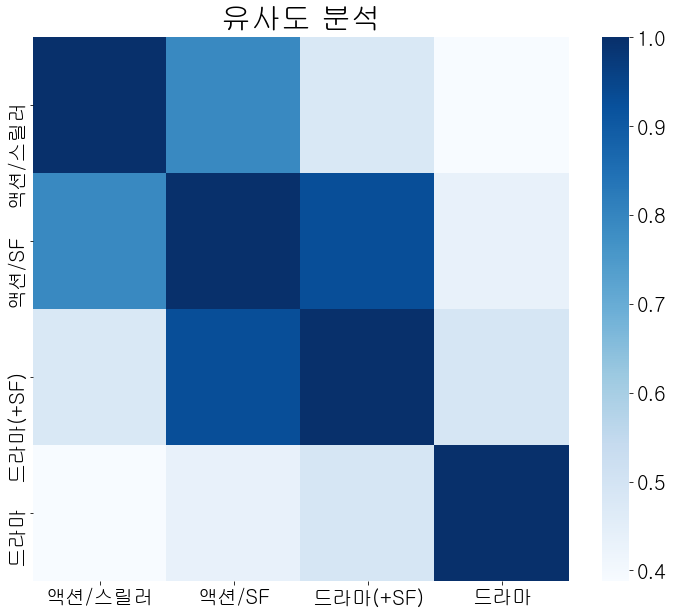

In [20]:
from matplotlib import font_manager, rc

font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)


plt.figure(figsize=(12,10))
plt.title("유사도 분석",pad=10)
plt.rc('axes', titlesize=30)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

ax = sns.heatmap(df1, cmap = "Blues")